In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
#change the directory to the one where the script is located
print("current directory: ", os.getcwd())
os.chdir("..")
print("changed directory to: ", os.getcwd())

current directory:  /Users/apple/Documents/GitLab_Projects/master_project/xx823/notebooks
changed directory to:  /Users/apple/Documents/GitLab_Projects/master_project/xx823


In [11]:
#load all the json results from extension/results/summary_evaluations_paperqa2 and create a dataframe

import pandas as pd
import json
import os
import glob
from pathlib import Path

def load_json_files_to_dataframe(directory_path="extension/results/summary_evaluations_paperqa2"):
    """
    Load all JSON files from the specified directory and create a pandas DataFrame.
    
    Args:
        directory_path (str): Path to the directory containing JSON files
        
    Returns:
        pd.DataFrame: DataFrame containing all the evaluation data
    """
    
    # List to store all data
    all_data = []
    
    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist.")
        print("Please check the path or create the directory with JSON files.")
        return None
    
    # Find all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))
    
    if not json_files:
        print(f"No JSON files found in {directory_path}")
        return None
    
    print(f"Found {len(json_files)} JSON files")
    
    # Load each JSON file
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
                # Handle both single objects and arrays
                if isinstance(data, list):
                    all_data.extend(data)
                else:
                    all_data.append(data)
                    
                print(f"Loaded {json_file}: {len(data) if isinstance(data, list) else 1} records")
                
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON file {json_file}: {e}")
            continue
        except Exception as e:
            print(f"Error reading file {json_file}: {e}")
            continue
    
    if not all_data:
        print("No valid data found in JSON files")
        return None
    
    print(f"Total records loaded: {len(all_data)}")

     # Create DataFrame
    df = pd.DataFrame(all_data)
    
    # Normalize nested evaluation data
    if 'evaluation' in df.columns:
        # Extract evaluation metrics into separate columns
        eval_df = pd.json_normalize(df['evaluation'])
        eval_df.columns = ['eval_' + col for col in eval_df.columns]
        
        # Combine with main dataframe
        df = pd.concat([df.drop('evaluation', axis=1), eval_df], axis=1)
    
    return df

In [12]:
def display_dataframe_info(df):
    """
    Display information about the created DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
    """
    if df is None:
        return
        
    print("\n" + "="*50)
    print("DATAFRAME INFORMATION")
    print("="*50)
    
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\nColumn Types:")
    print(df.dtypes)
    
    print("\nFirst few rows:")
    print(df.head())
    
    if 'eval_conciseness_score' in df.columns:
        print("\nEvaluation Score Statistics:")
        score_columns = [col for col in df.columns if col.startswith('eval_') and col.endswith('_score')]
        print(df[score_columns].describe())
    
    print("\nMissing values:")
    print(df.isnull().sum())

In [14]:
#check if the question is unique
def check_unique_questions(df):
    """
    Check if the questions in the DataFrame are unique.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze
        
    Returns:
        bool: True if questions are unique, False otherwise
    """
    if df is None:
        return False
    
    unique_questions = df['question'].nunique()
    total_questions = len(df)
    
    print(f"Unique questions: {unique_questions} out of {total_questions}")
    
    return unique_questions == total_questions

#check if the questions are unique
unique = check_unique_questions(df)
#remove duplicates if they are not unique
if not unique:
    df = df.drop_duplicates(subset=['question'])
    print(f"Removed duplicates. New shape: {df.shape}")
else:
    print("No duplicates found. DataFrame is unique.")

Unique questions: 105 out of 105
No duplicates found. DataFrame is unique.


In [15]:
pd.options.display.max_colwidth=5000

In [16]:
#find the number of paperqa2 response contains "I cannot answer."


count = df[df['paperqa2_answer'].str.contains("I cannot answer", na=False)]
  
#do not show ...
print(f"Number of responses containing 'I cannot answer.': {len(count)}")
count

Number of responses containing 'I cannot answer.': 13


,question,paperqa2_answer,ideal_answer,expected_citations,key_passage,source_file,timestamp,eval_conciseness_score,eval_accuracy_score,eval_citation_score,eval_rationale,eval_manual_score,eval_examples
1,How much does the ACT DR6 power spectra improve white noise levels over previous results?,I cannot answer.,ACT DR6 power spectra white noise levels improve over those of Planck by roughly a factor of 3 with polarization and a factor of two in temperature.,p4; sec2.1,These power spectra have white noise levels that improve over those of Planck by roughly a factor of 3 with polarization and a factor of two in temperature.,https://arxiv.org/abs/2503.14454,2025-05-21T21:37:06.400340,1,1,1,"The response 'I cannot answer' is entirely uninformative and fails to provide any of the key information required by the question. It does not address the improvement factors in white noise levels for polarization and temperature as specified in the ideal answer. Consequently, it scores the lowest possible on conciseness and accuracy, as it does not convey any relevant information. Additionally, there are no citations provided, resulting in the lowest score for citation quality as well. The response does not meet any of the criteria for a scientific summary.",1.0,NaN
13,What is the effect of blending on the NIR Wesenheit magnitude?,I cannot answer.,The blending largely cancels,p9; sec2.1,"However, the effect of blending largely cancels when determining the color F555W−F814W used to measure Cepheid distances via equation (1)",https://arxiv.org/abs/1604.01424v3,2025-05-21T20:28:52.360903,1,1,1,"The provided answer 'I cannot answer' is extremely lacking in all aspects. It does not provide any information related to the effect of blending on the NIR Wesenheit magnitude, making it not concise at all. In terms of accuracy, it fails to address the question or align with the ideal answer, which states that the effect of blending largely cancels. Furthermore, there are no citations provided, which is a critical omission given the expected citations from the source material. Overall, the response is fundamentally flawed and does not meet any of the evaluation criteria.",1.0,NaN
17,What was the exposure time of the 1995al SN 1a in the optical band of the HST?,"I cannot answer. The provided excerpts from the paper do not contain any information regarding the exposure time of the 1995al SN Ia in the optical band of the Hubble Space Telescope (HST). Each section consistently emphasizes cosmological parameters and results from the Planck satellite, with no mention of supernovae or specific observational details related to HST exposure times (aghanim2020planck2018results pages 10-11, 11-11, 13-13, 14-15, 15-16, 16-17, 17-17, 17-18, 18-19, 19-19, 19-21, 24-24, 24-25, 25-26, 26-27).",2962 seconds,p7; T1,None,https://arxiv.org/abs/1604.01424v3,2025-05-21T20:19:51.597745,5,1,1,"The provided answer is concise in stating that the information is not available, but it fails to address the question directly, resulting in a low conciseness score. The accuracy score is extremely low because the answer does not provide the correct exposure time of 2962 seconds, as stated in the ideal answer. Additionally, the citation score is minimal because the answer does not reference the expected citations (p7; T1) and instead lists irrelevant sections from a different context. An example from the text is the focus on cosmological parameters and Planck satellite results, which are unrelated to the question about HST exposure time.",1.0,NaN
31,What is the median difference in the optical Wesenheit magnitude for host N3972?,I cannot answer.,25 mmag,p10; T2,None,https://arxiv.org/abs/1604.01424v3,2025-05-21T20:45:48.416355,1,1,1,"The provided answer 'I cannot answer' is extremely lacking in all evaluation criteria. For conciseness, it scores a 1 because it does not provide any relevant information or attempt to address the question. In terms of accuracy, it scores a 1 as well, since it d

ANALYSIS OF 'I CANNOT ANSWER' REASONS
Total 'I cannot answer' responses: 13

Breakdown by reason:
  MATH_problem: 6 (46.2%)
  RAG_problem: 7 (53.8%)


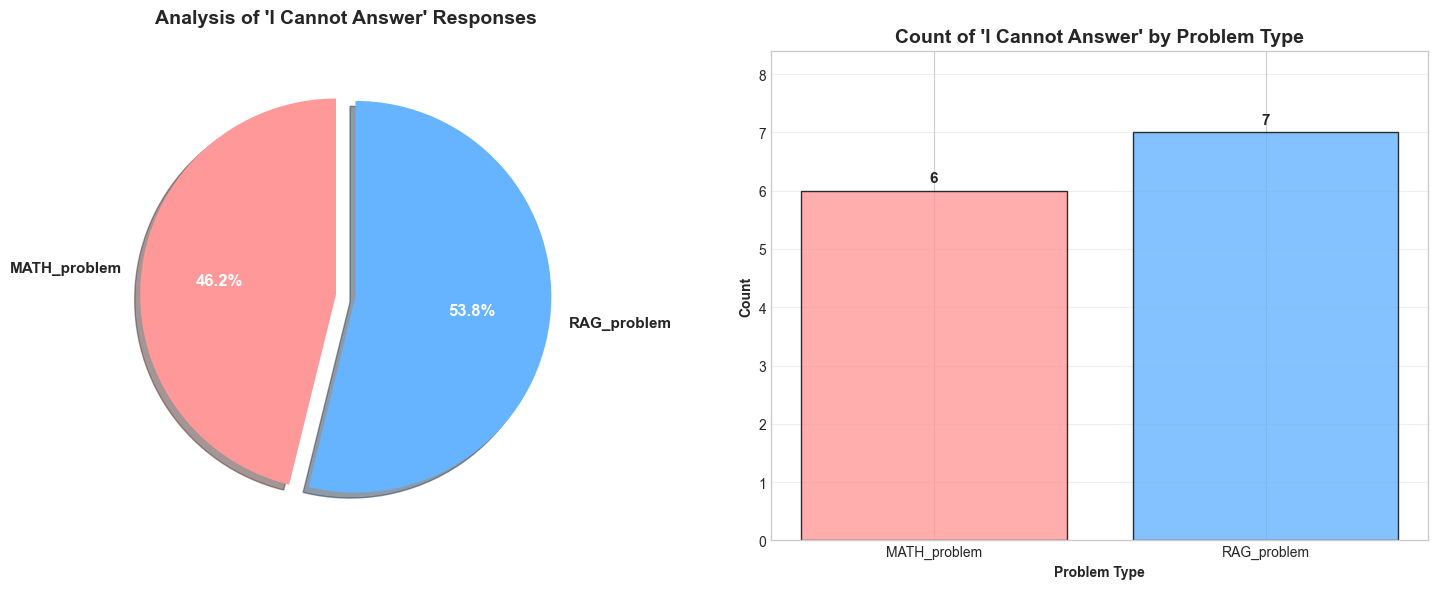

In [18]:
#analyse the reasons for count dataframe
import matplotlib.pyplot as plt
MATH_problem=6
RAG_problem=7
reasons_dict={
    "MATH_problem": MATH_problem,
    "RAG_problem": RAG_problem
}


# Calculate total and percentages
total_count = sum(reasons_dict.values())
percentages = {k: (v/total_count)*100 for k, v in reasons_dict.items()}

print("ANALYSIS OF 'I CANNOT ANSWER' REASONS")
print("=" * 50)
print(f"Total 'I cannot answer' responses: {total_count}")
print("\nBreakdown by reason:")
for reason, count in reasons_dict.items():
    pct = percentages[reason]
    print(f"  {reason}: {count} ({pct:.1f}%)")

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie Chart
colors = ['#ff9999', '#66b3ff']  # Light red and light blue
wedges, texts, autotexts = ax1.pie(
    reasons_dict.values(), 
    labels=reasons_dict.keys(), 
    autopct='%1.1f%%', 
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05),  # Slightly separate the slices
    shadow=True
)

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')

ax1.set_title("Analysis of 'I Cannot Answer' Responses", 
                fontsize=14, fontweight='bold', pad=20)

# Bar Chart
bars = ax2.bar(reasons_dict.keys(), reasons_dict.values(), 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', 
            fontweight='bold', fontsize=11)

ax2.set_title("Count of 'I Cannot Answer' by Problem Type", 
                fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')
ax2.set_xlabel('Problem Type', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Set y-axis to start from 0 and add some padding
ax2.set_ylim(0, max(reasons_dict.values()) * 1.2)

plt.tight_layout()
plt.show()



In [19]:
#calculate the average of the evaluation scores

AI_score_columns=['eval_conciseness_score','eval_accuracy_score', 'eval_citation_score']
human_score_columns=['eval_manual_score']

print("AI score average: ", df[AI_score_columns].mean().sum())
print("Human score average: ", df[human_score_columns].mean())

AI score average:  51.56190476190476
Human score average:  eval_manual_score    44.557692
dtype: float64


In [49]:
#normalized_accuracy_score
df['normalized_accuracy_score'] = df['eval_accuracy_score'].apply(lambda x: x* (10/7))
df['normalized_accuracy_score'] = df['normalized_accuracy_score'].round(2)

/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_49687/3879701261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalized_accuracy_score'] = df['eval_accuracy_score'].apply(lambda x: x* (10/7))
/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_49687/3879701261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalized_accuracy_score'] = df['normalized_accuracy_score'].round(2)


In [50]:
df.columns

Index(['question', 'paperqa2_answer', 'ideal_answer', 'expected_citations',
       'key_passage', 'source_file', 'timestamp', 'eval_conciseness_score',
       'eval_accuracy_score', 'eval_citation_score', 'eval_rationale',
       'eval_manual_score', 'eval_examples', 'normalized_accuracy_score'],
      dtype='object')

In [51]:
def plot_average_scores(df):
    """
    Calculate averages of normalized_accuracy_score and eval_manual_score
    and plot them as a bar chart
    """
    # Calculate averages
    avg_normalized = df['normalized_accuracy_score'].mean()
    avg_manual = df['eval_manual_score'].mean()
    
    # Prepare data for plotting
    metrics = ['Normalized Accuracy Score', 'Manual Evaluation Score']
    averages = [avg_normalized, avg_manual]
    
    # Create the bar p
    fig, ax = plt.subplots(figsize=(10, 8))
    
    bars = ax.bar(metrics, averages, 
                  color=['skyblue', 'lightcoral'], 
                  alpha=0.8, 
                  edgecolor='black', 
                  linewidth=1)
    
    # Customize the plot
    ax.set_ylabel('Average Score', fontsize=12)
    ax.set_title('Average Scores Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 100)  # Assuming scores are between 0 and 1
    
    # Add value labels on top of bars
    for bar, avg in zip(bars, averages):
        height = bar.get_height()
        ax.annotate(f'{avg:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 5),  # 5 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print the averages
    print(f"Average Normalized Accuracy Score: {avg_normalized:.3f}")
    print(f"Average Manual Evaluation Score: {avg_manual:.3f}")
    print(f"Difference: {abs(avg_normalized - avg_manual):.3f}")

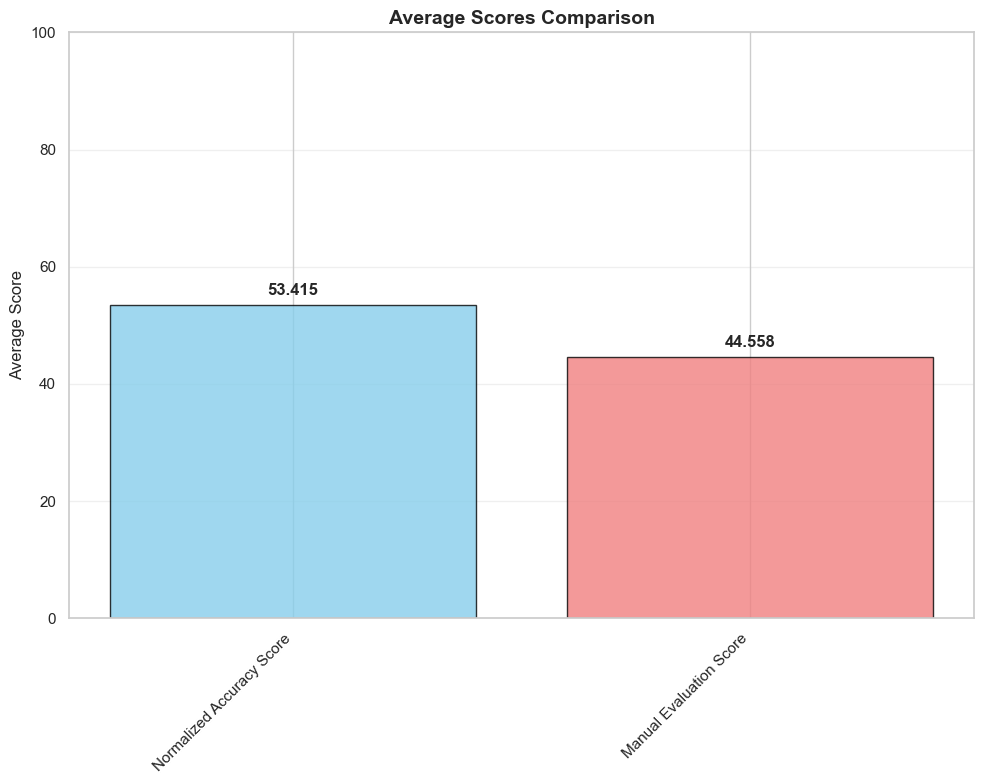

Average Normalized Accuracy Score: 53.415
Average Manual Evaluation Score: 44.558
Difference: 8.858


In [52]:
plot_average_scores(df)

In [ ]:
# Function to fix individual URLs
def fix_url(url):
    if pd.isna(url):
        return url
        
    # Fix v1 URLs - all should point to https://arxiv.org/abs/2201.02202v1
    if url.endswith('v1'):
        return 'https://arxiv.org/abs/2201.02202v1'
    
    # Fix v2 URLs - all should point to https://arxiv.org/abs/2010.00619v2
    elif url.endswith('v2'):
        return 'https://arxiv.org/abs/2010.00619v2'
    
    # Keep other URLs as they are
    else:
        return url

# Apply the fix to the source_file column
df['source_file'] = df['source_file'].apply(fix_url)


/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_19113/4278296040.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['source_file'] = df['source_file'].apply(fix_url)


In [ ]:
df['AI_score_sum']=df[AI_score_columns].sum(axis=1, skipna=True)

/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_19113/790406551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AI_score_sum']=df[AI_score_columns].sum(axis=1, skipna=True)


/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_19113/1158669814.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=melted_df, x='Score Type', y='Score', palette='Set2')


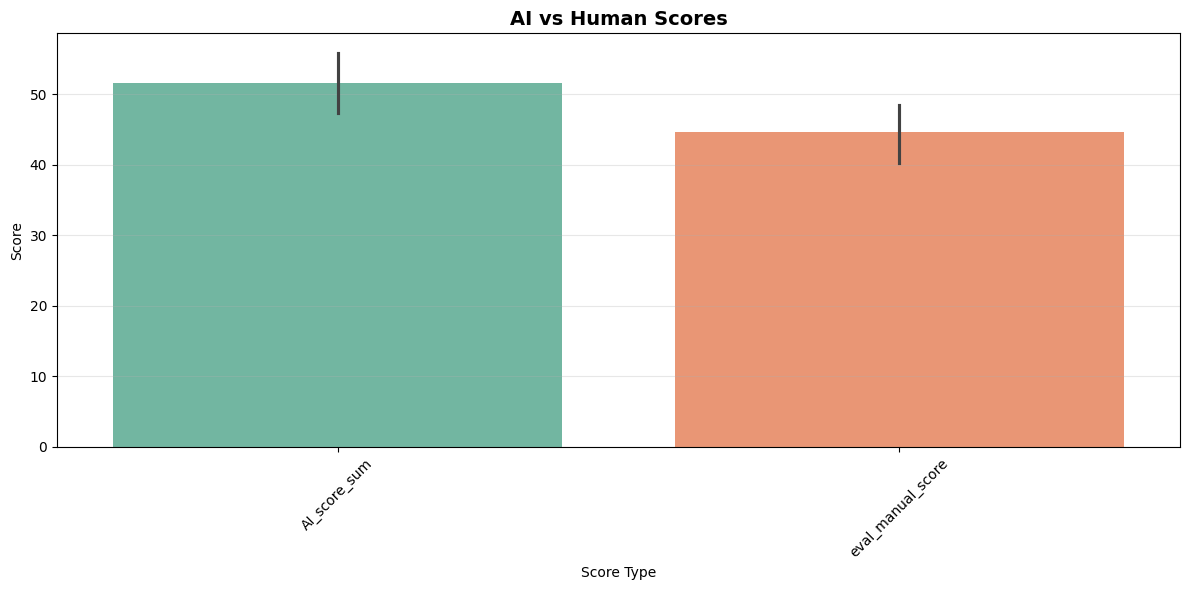

In [ ]:
#plot human and AI scores using sns
import seaborn as sns
import matplotlib.pyplot as plt

# Create box plots for each score type
score_columns=['AI_score_sum','eval_manual_score']
title = "AI vs Human Scores"
plt.figure(figsize=(12, 6))
melted_df = df.melt(value_vars=score_columns, var_name='Score Type', value_name='Score')

sns.barplot(data=melted_df, x='Score Type', y='Score', palette='Set2')
plt.title(title, fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()




In [ ]:
#

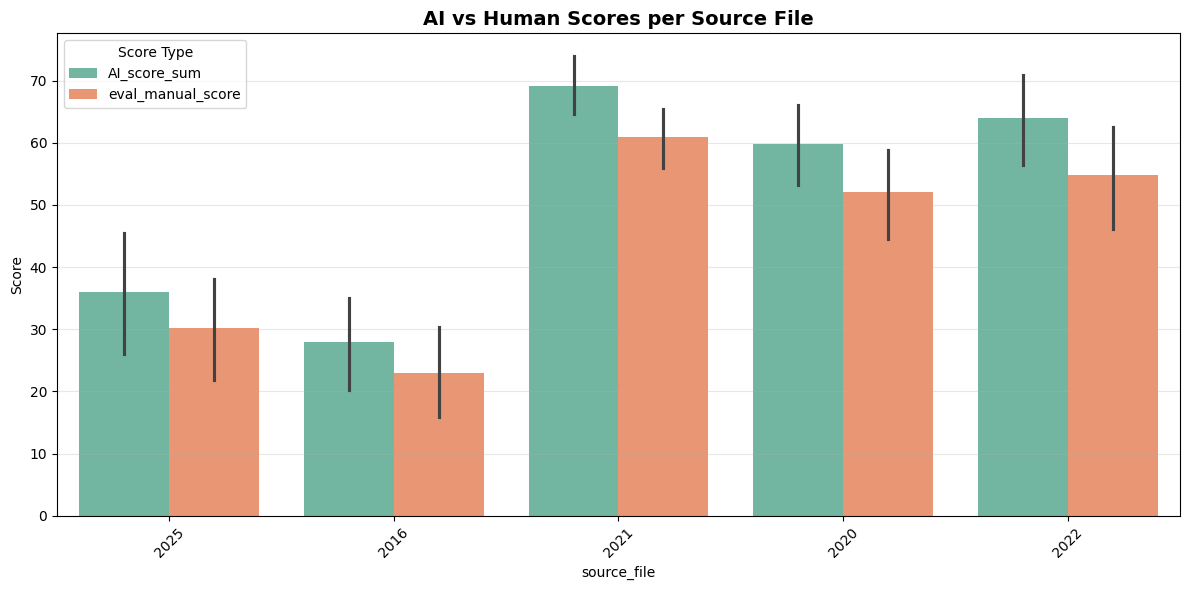

In [ ]:
#per source_file, plot the AI and human scores
# Create bar plots for each source_file containing the AI and human scores
score_columns=['AI_score_sum','eval_manual_score']
title = "AI vs Human Scores per Source File"
plt.figure(figsize=(12, 6))

melted_df = df.melt(id_vars=['source_file'], value_vars=score_columns, var_name='Score Type', value_name='Score')

#change the source_file to the date of the source_file
def change_source_file(source_file):
    if source_file=='https://arxiv.org/abs/1807.06209v4':
        return '2020'
    elif source_file=='https://arxiv.org/abs/2010.00619v2':
        return '2021'
    elif source_file=='https://arxiv.org/abs/2201.02202v1':
        return '2022'
    elif source_file=='https://arxiv.org/abs/1604.01424v3':
        return '2016' 
    else:
        return '2025'

melted_df['source_file'] = melted_df['source_file'].apply(change_source_file)  # Keep only the last part of the path
sns.barplot(data=melted_df, x='source_file', y='Score', hue='Score Type', palette='Set2')
plt.title(title, fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()


In [ ]:
#rename the 